In [1]:
## import package here
## If IDE is used, please make sure the 
## pakage is also included in your project interpreter


## connect to database
## make sure the MySQL database is running
## please change the user and password to yours
## please establish new database yelp_db for the first time


In [2]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import mysql.connector
from collections import OrderedDict
connection = mysql.connector.connect(
    user='root',
    password='qiuran1223',
    host='127.0.0.1',
    port=3306,
    database='yelp_db')


/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
data = pd.read_sql('''select business.id, business.name, business.neighborhood, business.city, business.latitude, business.longitude, category.category
  FROM category
  inner join business on
  business.id = category.business_id
  WHERE business.city ="Las Vegas"
  and neighborhood IS NOT NULL
  and category.category = "Italian" or category.category = "Mexican" or category.category = "American (New)"
  or category.category = "Chinese" or category.category = "Korean" or category.category = "Japanese"
  or category.category = "Barbeque" or category.category = "Thai" or category.category = "Mediterranean"
  GROUP BY business.id, category.category''',connection) 

In [4]:
from sklearn.cluster import KMeans
cluster_table = data.loc[data['city'] == 'Las Vegas']
cluster_table = cluster_table[['latitude','longitude','neighborhood','category']]
neighborhoods = cluster_table.neighborhood.unique()
list(neighborhoods)

['Southeast',
 'Spring Valley',
 'Westside',
 'Anthem',
 'Centennial',
 'The Strip',
 'Eastside',
 '',
 'Downtown',
 'Sunrise',
 'Northwest',
 'Chinatown',
 'Southwest',
 'Summerlin',
 'University',
 'The Lakes',
 'South Summerlin']

In [5]:
cluster_table = cluster_table[cluster_table.neighborhood!='University']
cluster_table = cluster_table[cluster_table.neighborhood!='']
cluster_table = cluster_table[cluster_table.neighborhood!='Chinatown']
neighborhoods = cluster_table.neighborhood.unique()
neighborhoods = list(neighborhoods)


In [6]:
stringStore=np.empty(14, dtype=str)

for i in range(0,14):
    stringStore[i]=neighborhoods[i]
    cluster_table['neighborhood'].replace(neighborhoods[i], i, inplace=True)

In [7]:
categoriesPre = cluster_table.category.value_counts()
categories = list(categoriesPre.index)
categoriesPre

Mexican           590
American (New)    507
Italian           337
Chinese           276
Japanese          251
Barbeque          150
Thai              114
Mediterranean     100
Korean             58
Name: category, dtype: int64

In [8]:
categories


['Mexican',
 'American (New)',
 'Italian',
 'Chinese',
 'Japanese',
 'Barbeque',
 'Thai',
 'Mediterranean',
 'Korean']

In [9]:



stringCat=np.empty(9, dtype=str)
stringfull=np.empty(9, dtype="S15")

for i in range(0,9):
    stringCat[i]= categories[i]
    stringfull[i] = categories[i]
    cluster_table['category'].replace(categories[i], i, inplace=True)


In [10]:
df = cluster_table[['latitude','longitude','category','neighborhood']].copy()
df[['latitude','longitude']] = (df[['latitude','longitude']].sub(df[['latitude','longitude']].mean())).divide(df[['latitude','longitude']].std())
for i in range(0,9):
    df['category'].replace(i, stringCat[i], inplace=True)



In [11]:
def topCategories(categoryList):
    n = []
    for i in categoryList:
         n += [i.split(',')]   
    count={}
    for i in n:
        for j in i:
            if j not in count:
                count[j]=1
            else:
                count[j] = count[j] +1
    return OrderedDict(sorted(count.items(), key=lambda a:a[1], reverse=True))  


In [12]:
 
topDf = df.copy()
categoryList = df['category'].tolist()
top = list(topCategories(categoryList))[0:10]
topCatNames=[]
topCatNames = top


In [13]:

c =[]
def convert(j):
    for i in top:
        if(i == j):
            return(top.index(i)+1)


In [14]:

for i in df['category']:
    row = i.split(',')
    c += [[convert(j) for j in row if j in top]]
topDf['category'] = c
topDf = topDf.reset_index(drop = True)
a = np.zeros(shape=(len(topDf['category']),9))
i=0
for j in c:
    for k in j:
        a[i,k-1]=1
    i+=1
top = pd.DataFrame.from_records(a)
top[['latitude','longitude']] = topDf[['latitude','longitude']]


In [15]:
stringCat[1]



'A'

Text(0,0.5,'error')

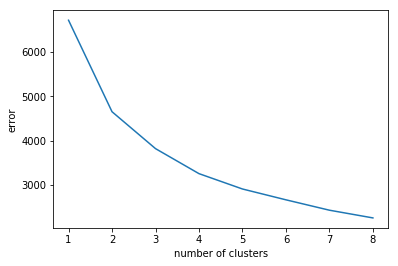

In [16]:

n = 9

error = np.zeros(n)
error[0] = 0;
for k in range(1,n):
    kmeans = KMeans(init='k-means++', n_clusters=k,n_init=10)
    kmeans.fit_predict(top)
    error[k] = kmeans.inertia_
plt.figure(1)
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('number of clusters')
plt.ylabel('error')


In [17]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=100) 
km = kmeans.fit_predict(top)
labels = kmeans.labels_
print("the silhouette score is")
print(silhouette_score(top, labels, metric='euclidean'))
print("calinski_harabaz_score")
print(metrics.calinski_harabaz_score(top, labels) )

the silhouette score is
0.27073199724131664
calinski_harabaz_score
844.3707871472009


In [18]:

    

        
def labels(cluster):
    count = {}
    for i in cluster[0]:
        for j in topDf['category'][i]:
            if j not in count:
                count[j] = 1
            else:
                count[j] +=1
    return OrderedDict(sorted(count.items(), key=lambda kv:kv[1], reverse=True))



In [19]:
topCounts = list(topCategories(categoryList).values())[0:10]
labelsKm = []
km0 = np.where(km==0)
lc = labels(km0)


In [20]:
def clusterLabel(lc,topCounts):
    maxx = 0
    
    for key,value in lc.items():
        temp = value/topCounts[key-1]
        if(temp>maxx):
            maxx = temp
            index = key-1
    return categories[index]

In [21]:

labelsKm.append(clusterLabel(lc, topCounts))
labels(km0)


OrderedDict([(1, 72),
             (2, 36),
             (3, 33),
             (4, 31),
             (5, 24),
             (6, 17),
             (7, 13),
             (8, 5)])

In [22]:

km1 = np.where(km==1)
lc = labels(km1)
labelsKm.append(clusterLabel(lc, topCounts))

km2 = np.where(km==2)
lc = labels(km2)
labelsKm.append(clusterLabel(lc, topCounts))

km3 = np.where(km==3)
lc = labels(km3)
labelsKm.append(clusterLabel(lc, topCounts))
labelsKm


['Thai', 'Mediterranean', 'Barbeque', 'American (New)']

In [23]:
clusters = [km0,km1,km2,km3] # ,km2,km3,km4,km5


In [24]:

def createScatter(clusters):
    colors = ['red','orange','yellow','green','blue','purple','cyan','magenta','black','#9BF591',
             '#A34830','#6888CD','#03F1F6','#1A605E','#B8393C','#59BE80']
    x = 0
    for i in clusters:
        for j in i:
            plt.scatter(top['longitude'][j],top['latitude'][j], color=colors[x]) #org: lat, long
        x=x+1


In [25]:
def createCentroids(centroids):
    y = 0  
    for i in centroids:
        plt.scatter(i[10],i[9],s=50,c='black',marker='*',linewidth=2)
        plt.annotate(labelsKm[y],xy=(i[10],i[9]))
        y+=1


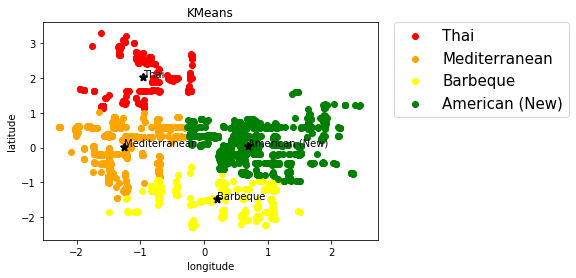

In [26]:

createScatter(clusters)
createCentroids(kmeans.cluster_centers_)

plt.title('KMeans')
plt.xlabel('longitude') 
plt.ylabel('latitude')
legend = plt.legend([labelsKm[i] for i in range(len(labelsKm))],bbox_to_anchor=(1.05, 1),
                    loc=2, borderaxespad=0.,fontsize=15)

plt.savefig('kmeans_cuisines.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


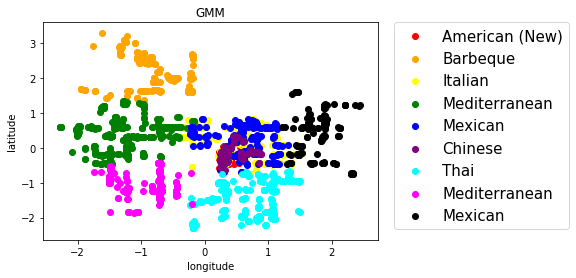

In [27]:
from sklearn import mixture
labelsGmm=[]
gmm = mixture.GMM(n_components=9,covariance_type='spherical')
gmm.fit(top)
gaussian = gmm.predict(top)
g0 = np.where(gaussian==0)
x= labels(g0)
labelsGmm.append(clusterLabel(x, topCounts))
g1 = np.where(gaussian==1)
x= labels(g1)
labelsGmm.append(clusterLabel(x, topCounts))
g2 = np.where(gaussian==2)
x= labels(g2)
labelsGmm.append(clusterLabel(x, topCounts))
g3 = np.where(gaussian==3)
x = labels(g3)
labelsGmm.append(clusterLabel(x, topCounts))
g4 = np.where(gaussian==4)
x = labels(g4)
labelsGmm.append(clusterLabel(x, topCounts))
g5 = np.where(gaussian==5)
x = labels(g5)
labelsGmm.append(clusterLabel(x, topCounts))

g6 = np.where(gaussian==6)
x = labels(g6)
labelsGmm.append(clusterLabel(x, topCounts))

g7 = np.where(gaussian==7)
x = labels(g7)
labelsGmm.append(clusterLabel(x, topCounts))

g8 = np.where(gaussian==8)
x = labels(g8)
labelsGmm.append(clusterLabel(x, topCounts))



clustersGmm = [g0,g1,g2,g3,g4,g5,g6,g7,g8] 
createScatter(clustersGmm)
plt.title('GMM')
plt.xlabel('longitude') 
plt.ylabel('latitude') 
legend = plt.legend([labelsGmm[i] 
                     for i in range(len(labelsGmm))],
                    bbox_to_anchor=(1.05, 1), loc=2, 
                    borderaxespad=0.,fontsize=15)
plt.show()